# Testing New Experiment API

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    qed_oracle = RDKitOracle('QED', descriptor='QED')
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, qed_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, qed_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))
# qed_utility = ClassicUtilityFunction(
#     qed_oracle, ideal=(0.65, 1.0), acceptable=(0.5, 1.0))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    # qed_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
    # qed_oracle.surrogate(sigma=0.1),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [5]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in assays:
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

Instantiate Environment and Agent.

In [6]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'grow', 'size': 8}}
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'replace', 'size': 8, 'temperature': 0.2}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
make = {'name': 'make', 'batch_size': 8}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8} # 8
design_and_score = [design_replace, score]

sequence = [*(design_and_score * 1), design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.25),
    utility_function = utility_agent
)

In [7]:
def display_best(experiment):
    import numpy as np
    observations = experiment.drug_env.library
    utilities = experiment.drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [ ]:
from dgym.experiment import Experiment

experiment = Experiment(
    drug_env=drug_env,
    drug_agent=drug_agent
)

result = experiment.run()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
-1.2109728050162327
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.41492501456476893
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374
0.48750961443430374


In [57]:
import seaborn as sns
experiment.drug_env.library.tested.annotations.reindex(
    columns=[*drug_env.assays, 'Current Status', 'Step Designed', 'Step Scored', 'Step Made', 'Step Tested'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Current Status,Step Designed,Step Scored,Step Made,Step Tested
0,5.610656,2.81392,-2.398377,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
1,4.014071,-0.68910,0.815571,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
2,5.662070,0.84602,-1.526523,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
3,6.001551,0.56420,-1.881980,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
4,5.357660,0.97710,-1.506146,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
3397,7.251178,2.30430,-4.084630,9.076791,1.536741,-2.946629,Tested,51.0,51.0,52.0,52
3406,7.996335,2.45300,-2.398602,9.357560,2.263504,-1.858596,Tested,51.0,51.0,52.0,52
3407,8.410086,2.35370,-6.295262,9.565448,2.099392,-4.758359,Tested,51.0,51.0,52.0,52
3408,8.622046,2.87702,-3.577405,9.894699,3.524618,-4.299399,Tested,51.0,51.0,52.0,52


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

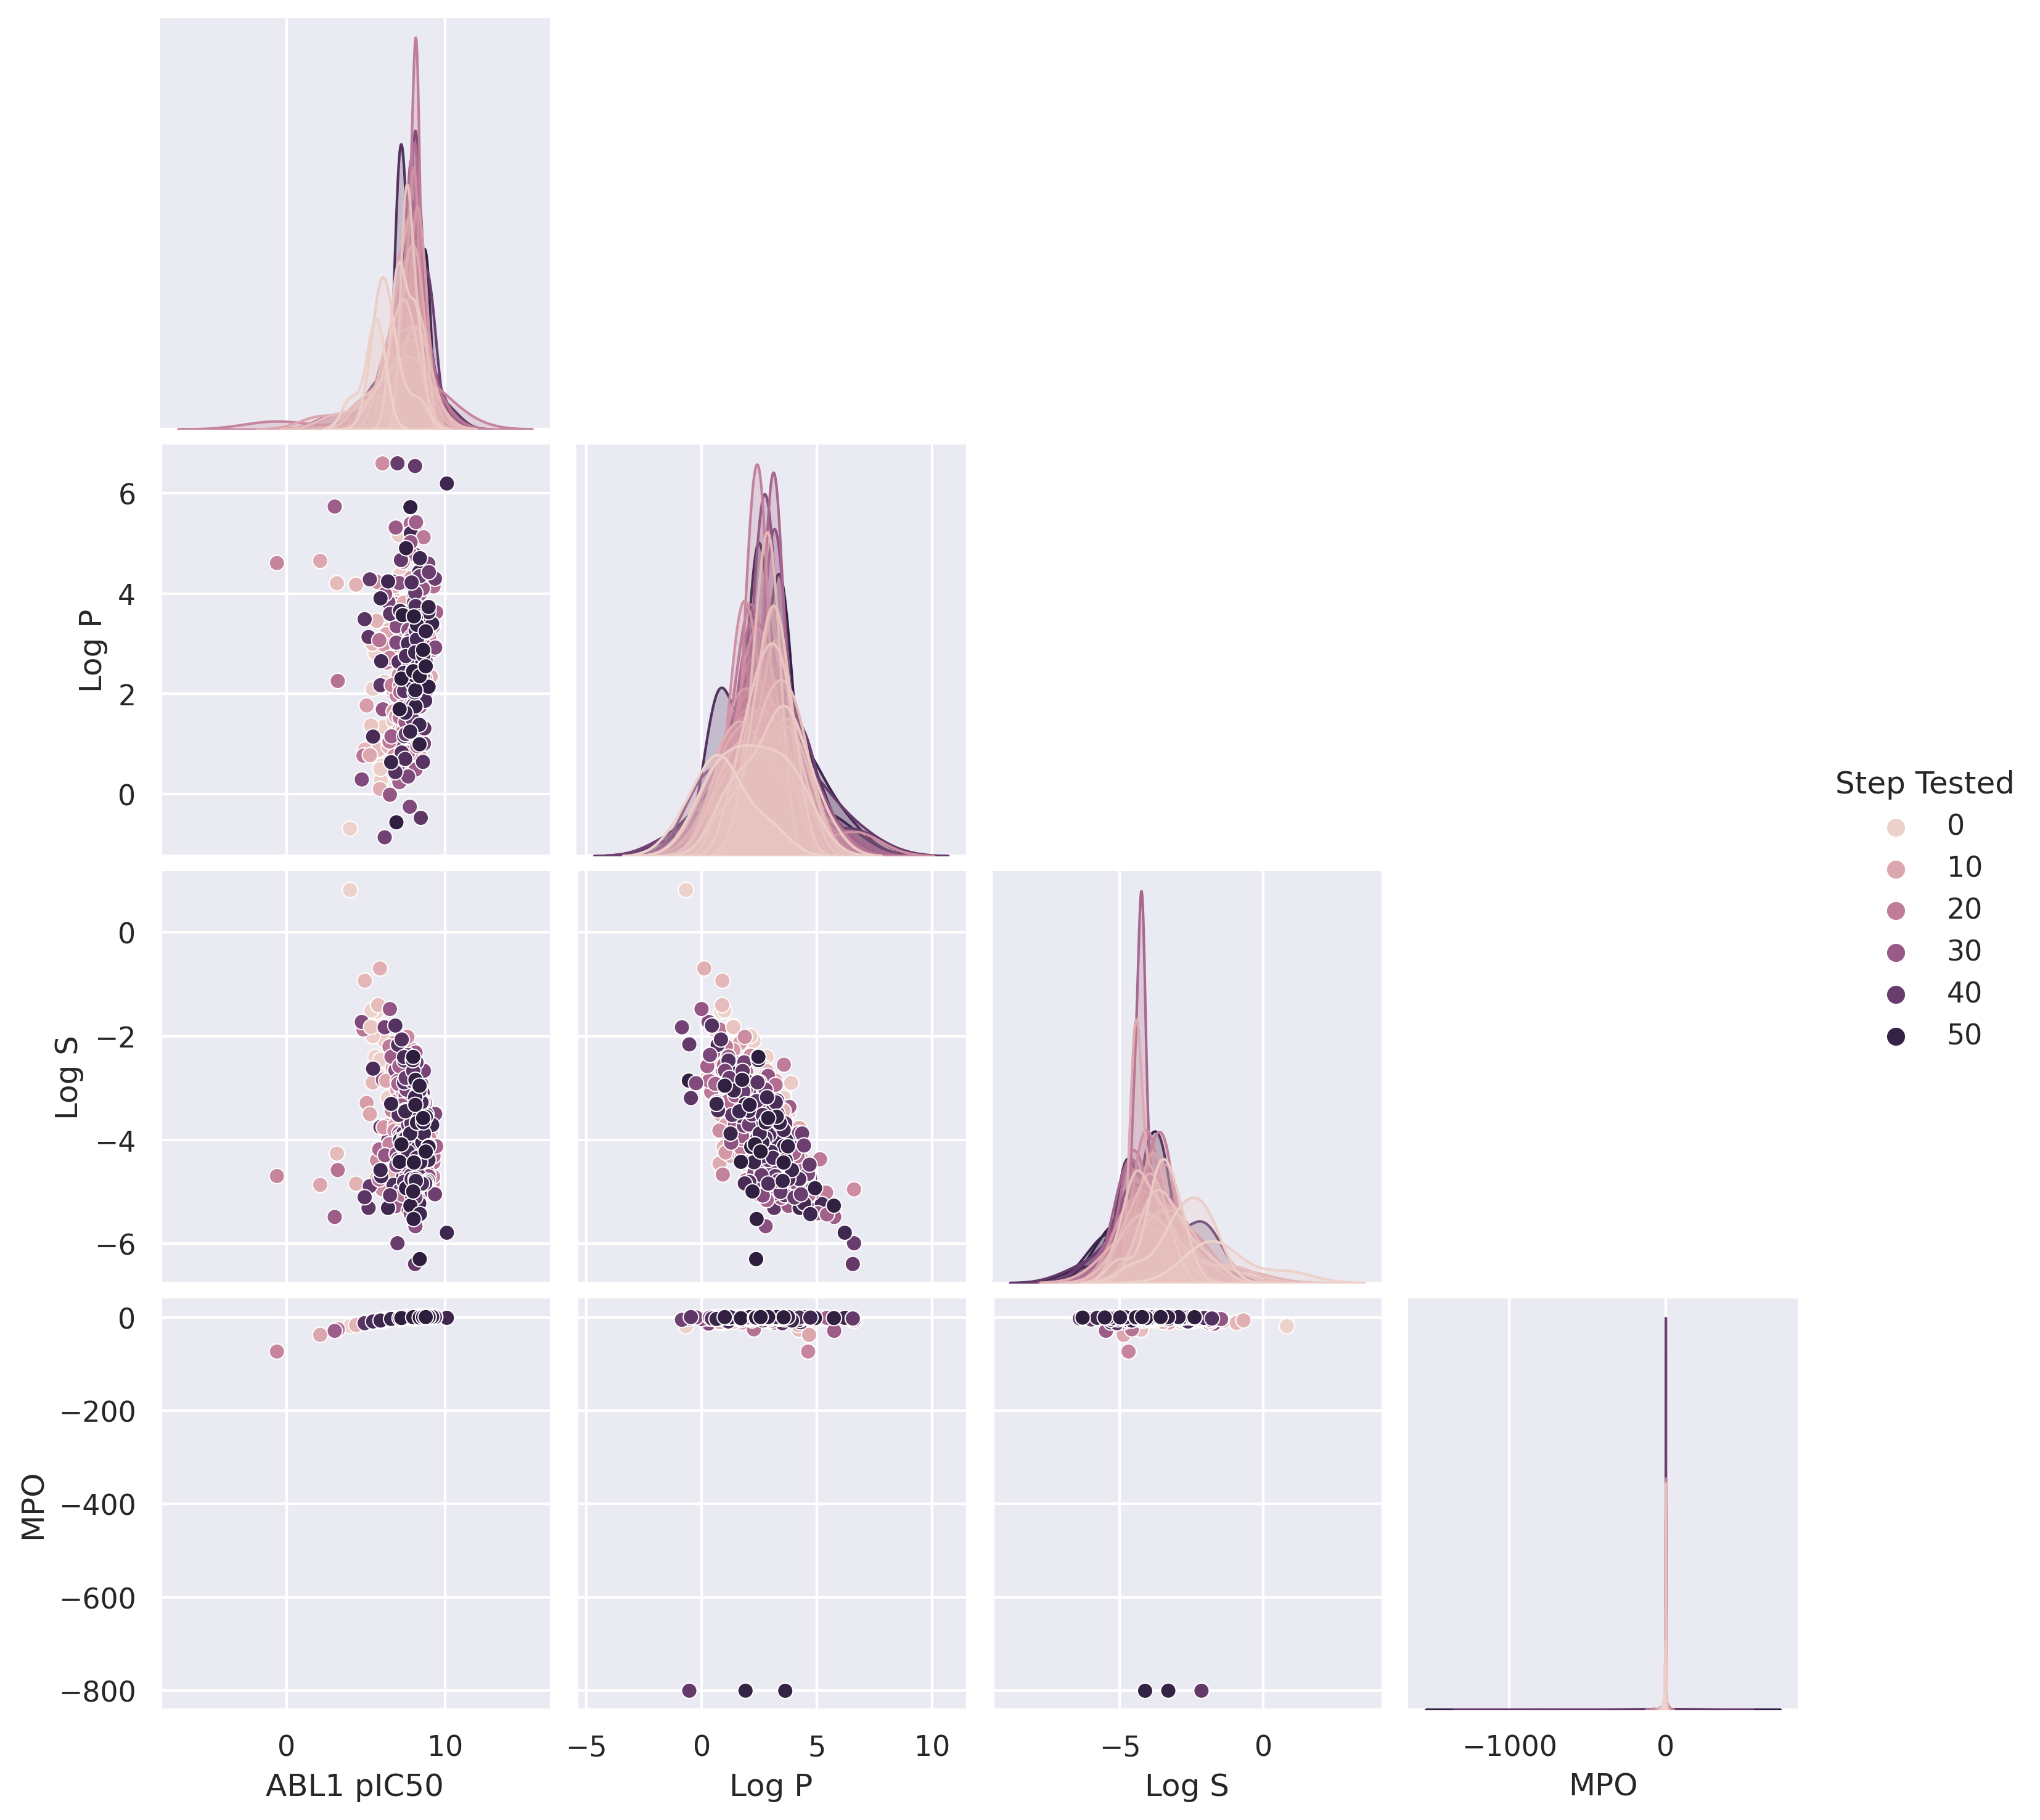

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(dpi=300)

pairplot_df = experiment.drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = experiment.drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [11]:
max_timestep = int(experiment.drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': int(t)})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

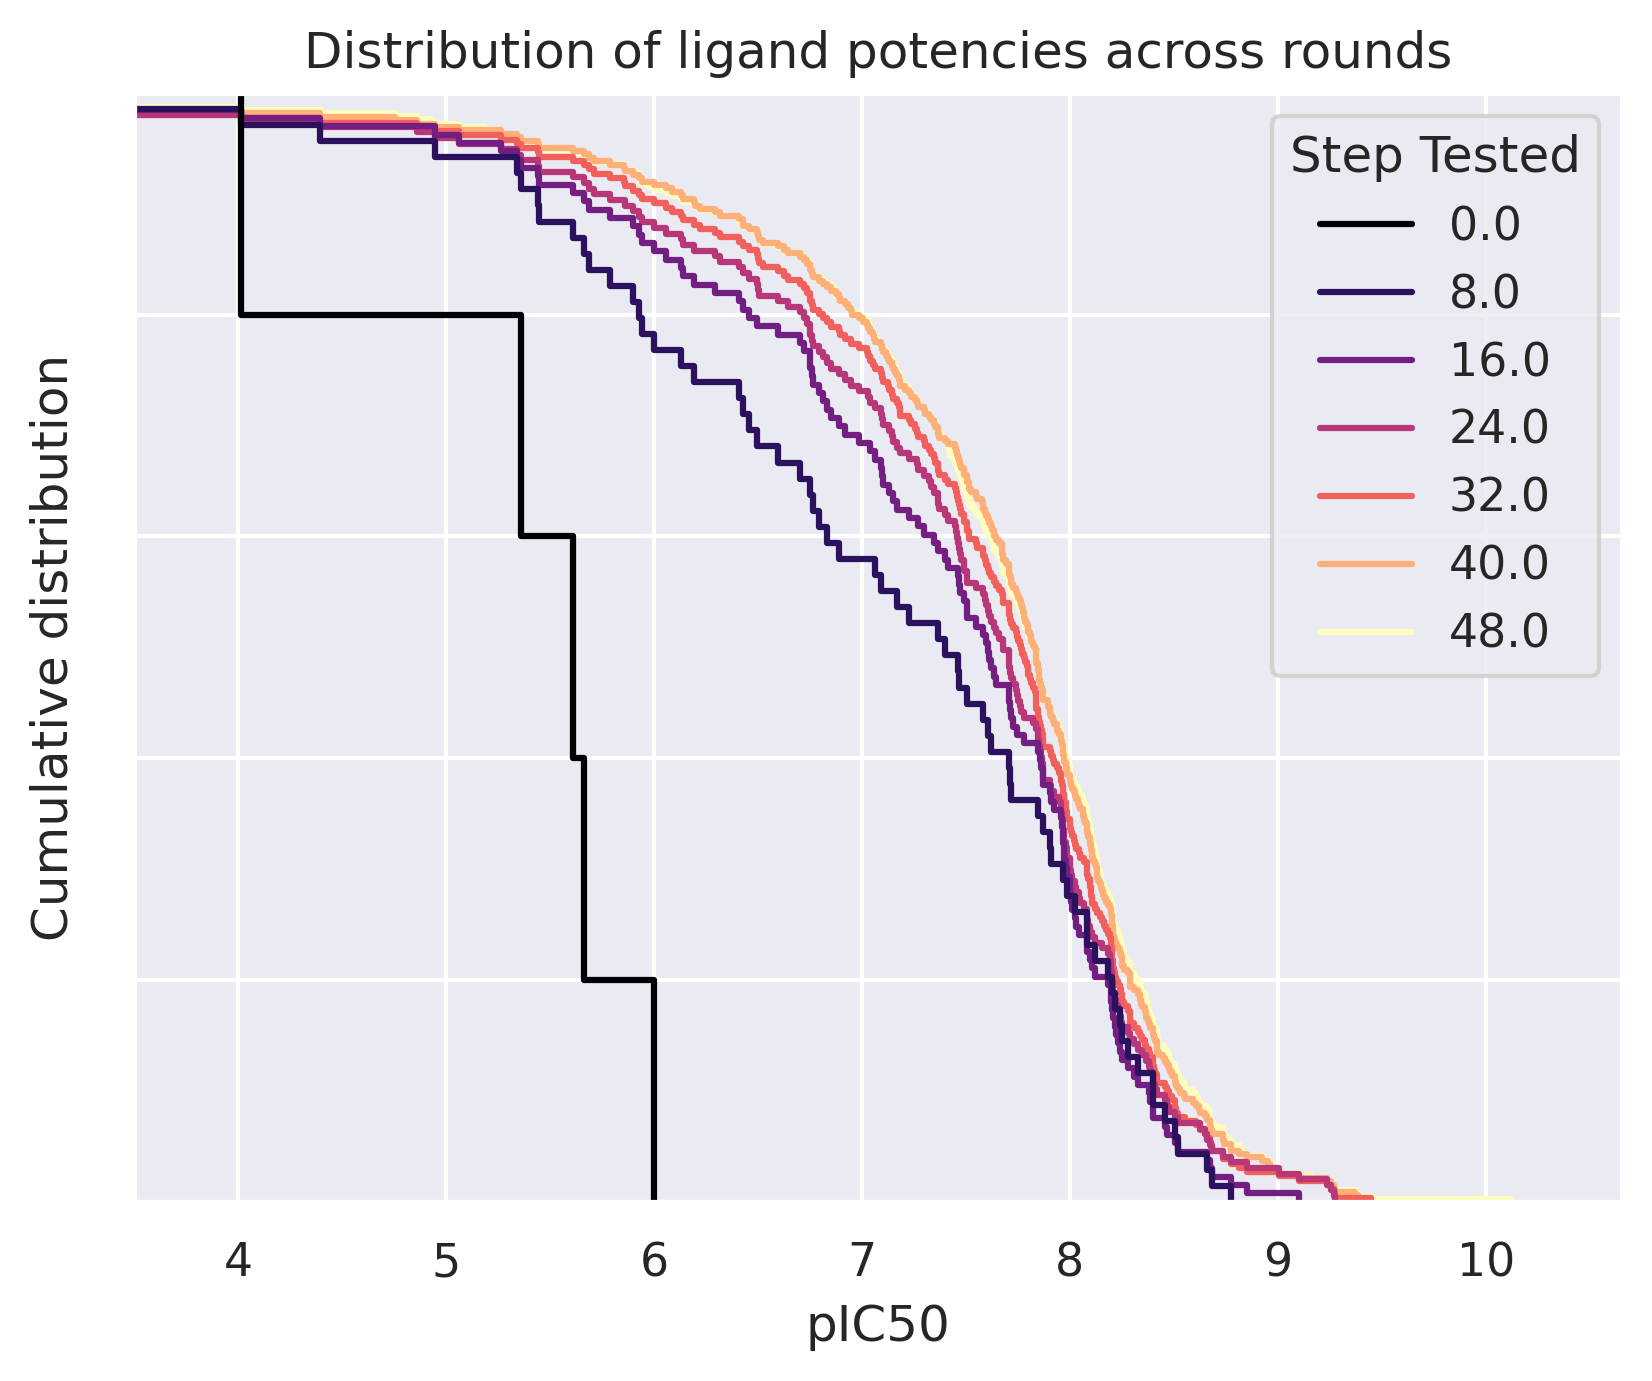

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('`Step Tested` % 8 == 0'),
    x='pIC50',
    hue='Step Tested',
    palette='magma',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

In [16]:
display_best(experiment)

,ABL1 pIC50,Log S,Log P,utility
2416,9.384262,-3.498643,2.92552,0.938273
3001,9.192504,-3.709949,3.40140,0.836002
673,9.099712,-3.865997,2.34342,0.786513
1224,9.005312,-3.959546,3.10792,0.736166
1990,9.448382,-4.121939,3.62850,0.719245


In [53]:
display_best(experiment)

,ABL1 pIC50,QED,Log S,Log P,utility
1941,9.349517,0.530259,-3.182481,1.5854,0.981752
3751,9.006238,0.793453,-3.222436,1.9620,0.977756
2558,9.259852,0.714511,-3.392674,2.0289,0.960733
2478,9.810155,0.562042,-3.402468,0.5471,0.959753
2429,9.207359,0.720624,-3.404347,1.8360,0.959565


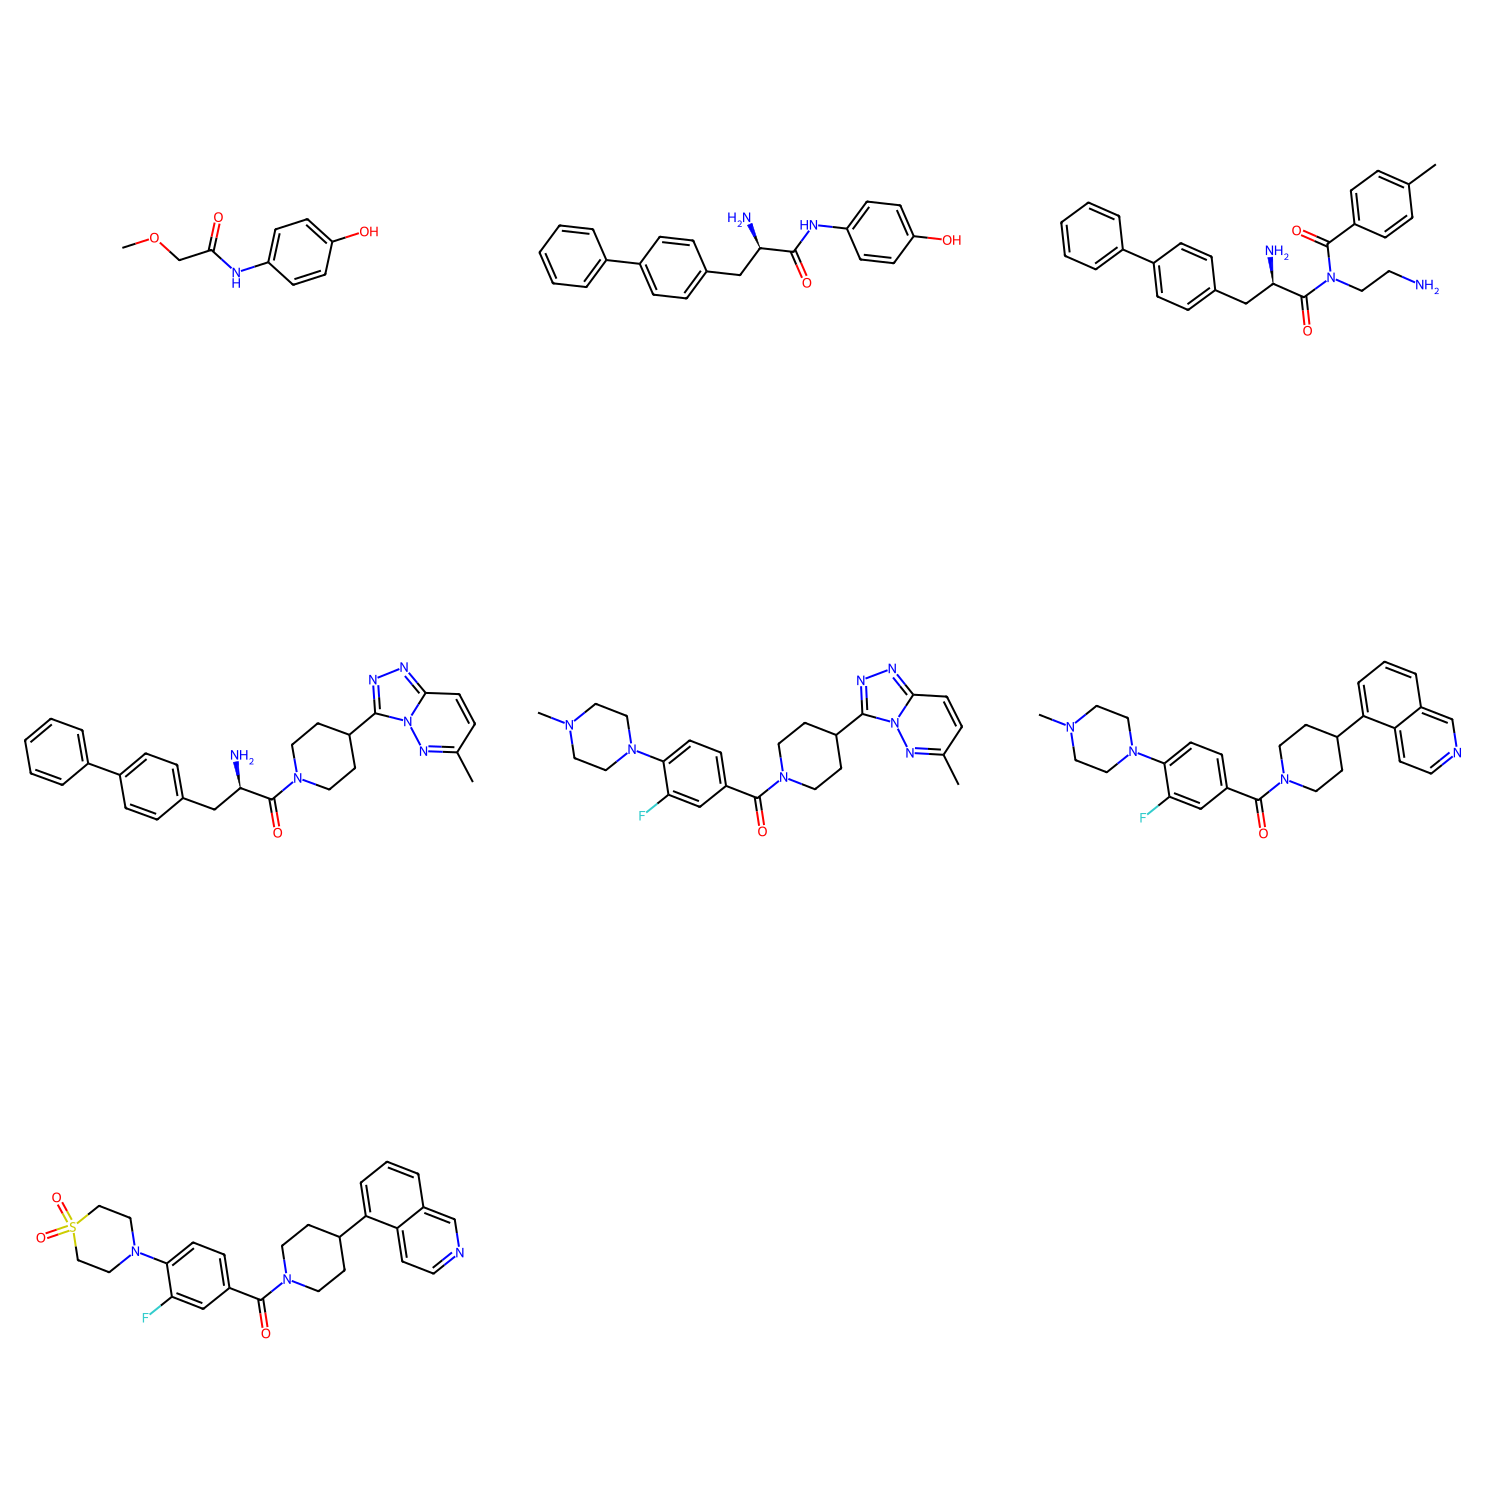

In [31]:
from rdkit.Chem.Draw import MolsToGridImage

molecule = experiment.drug_env.library[1990]
lineage = dg.utils.align_lineage(molecule)

MolsToGridImage([m.mol for m in lineage], subImgSize=(500, 500))

# Visualize trajectory

In [194]:
import seaborn as sns

palette = sns.color_palette("magma", as_cmap=True)

def normalize_array(arr):
    """
    Normalize a numpy array to have its minimum and maximum values scaled to 0 and 1, respectively.
    
    Parameters
    ----------
    arr : np.ndarray
        The input array to normalize.
    
    Returns
    -------
    np.ndarray
        The normalized array with values scaled between 0 and 1.
    
    Example
    -------
    >>> arr = np.array([10, 20, 30, 40, 50])
    >>> normalize_array(arr)
    array([0. , 0.25, 0.5 , 0.75, 1. ])
    """
    arr = np.array(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

In [527]:
import math
import numpy as np
import igraph as ig

graph_scores = []
adjacency_tuples = []
for molecule in experiment.drug_env.library.tested[::4]:
    lineage = molecule.lineage
    for idx in range(len(lineage) - 1):
        adjacency_tuple = (lineage[idx].name, lineage[idx+1].name)
        adjacency_tuples.append(adjacency_tuple)

g = ig.Graph.TupleList(set(adjacency_tuples), directed=True)

# Remove self-loops
g = g.simplify()

# # Get the in-degree of each vertex
# in_degrees = g.degree(mode='in')

# # Root vertices have an in-degree of 0
# root_vertices = [v.index for v in g.vs if in_degrees[v.index] == 0]

# # Add common ancestor
# roots = g.get_vertex_dataframe()['name'][root_vertices]
# g.add_vertex('parent')
# g.add_edges([
#     ('parent', root_name) for root_name in roots
# ])

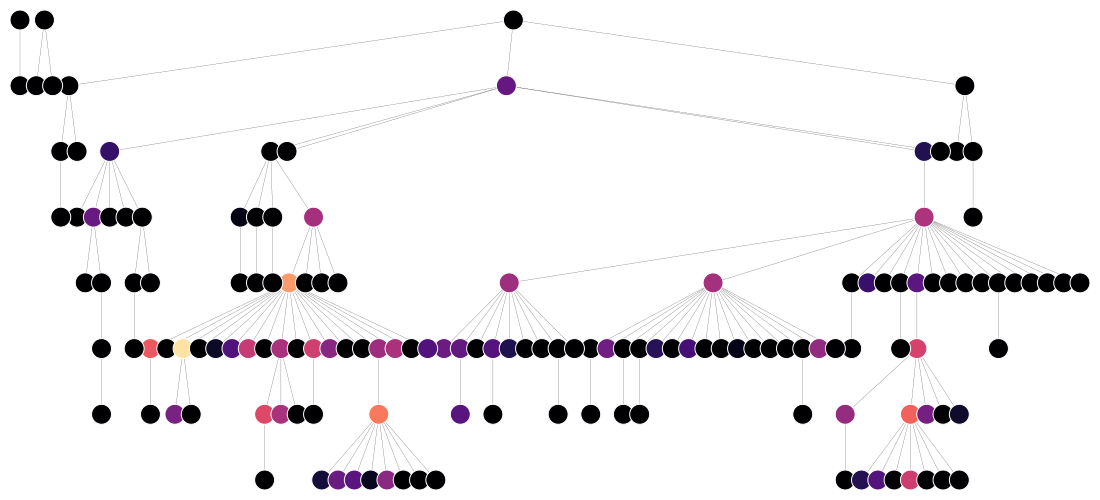

In [653]:
scores = [
    experiment.drug_env.utility_function(
        experiment.drug_env.library[v], use_precomputed=True, method='average')
    for v in g.get_vertex_dataframe()['name']
    if v != 'parent'
]

# Step 1: Identify leaves
# A leaf is a vertex with out-degree of 0
out_degrees = g.outdegree()
leaves = [idx for idx, degree in enumerate(out_degrees) if degree == 0]

# Step 2: Customize vertex colors and outlines
vertex_colors = [palette(score) for score in scores]
vertex_frame_colors = ['white'] * len(vertex_colors)
vertex_frame_width = [1.0] * len(vertex_colors)

# # Customize leaves
# for leaf in leaves:
#     vertex_frame_colors[leaf] = vertex_colors[leaf][:3]
#     vertex_colors[leaf] = vertex_colors[leaf][:3] + (0.05,)
#     vertex_frame_width[leaf] = 1.0 # 0.0

# Step 3: Plot the graph
visual_style = {
    "layout": g.layout("rt"),
    "bbox": (1_100, 500),
    "vertex_color": vertex_colors,
    "vertex_frame_color": vertex_frame_colors,
    "vertex_frame_width": vertex_frame_width,
    "edge_width": 0.25,
    "colorbar": palette,
    "edge_arrow_size": 0.0, # 0.3,
    "margin": 20,
    "vertex_size": 20,
}

ig.plot(g, **visual_style)

In [ ]:
from netgraph import Graph

coords = g.layout("rt")
x, y = zip(*coords.coords)
x = np.array([x_ / 20 for x_ in x])
y = np.array([y_ / -5 for y_ in y])
vertices = g.get_vertex_dataframe()['name'].tolist()
coord_dict = {i: (x[i], y[i]) for i, _ in enumerate(vertices)}
color_dict = {i: vertex_colors[i] for i, _ in enumerate(vertices)}

fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
Graph(
    g,
    node_layout=coord_dict,
    edge_width=0.20,
    node_color=color_dict,
    node_edge_color='white',
    node_edge_width=0.25,
    ax=ax
)

unique_y_ticks = np.unique(y)
ax.set_yticks(unique_y_ticks)
ax.set_yticklabels(reversed(range(len(unique_y_ticks))))
ax.set_ylabel('Generation')
ax.set_title('Molecule lineage')

plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: sans-serif
findfont: 